## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import math
from scipy.interpolate import griddata
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import numpy as np
import math
from scipy.io import readsav
from astropy import units as u
from astropy import constants as const
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import ndimage
import numpy as np
from scipy import ndimage as ndi
import scipy.interpolate as spi
from scipy.integrate import trapz

plt.style.use('../../Paul_style.txt')
#plt.rcParams['text.usetex'] = True

In [2]:
# GLOBAL PARAMS
h = 6.6260701e-34
c = 3e8


STAR_RADIUS   = 0.215 * 695700000
PLANET_RADIUS = 1.7469282e7

## Functions I might use

In [3]:
def specint(wn, spec, filtwn_list, filttrans_list): #from Ryan Challener's Theresa code
    """
    Integrate a spectrum over the given filters.
    Arguments
    ---------
    wn: 1D array
        Wavenumbers (/cm) of the spectrum 
        Hayley's note: be wary of these units! 
    spec: 1D array
        Spectrum to be integrated
    filtwn_list: list
        List of arrays of filter wavenumbers, in /cm.
    filttrans_list: list
        List of arrays of filter transmission. Same length as filtwn_list.
        Hayley's note: for now, this can just be an array you create of 1's and 0's. (1 where want to integrate over, 0 outside)
    Returns
    -------
    intspec: 1D array
        The spectrum integrated over each filter. 
    """
    if len(filtwn_list) != len(filttrans_list):
        print("ERROR: list sizes do not match.")
        raise Exception
    
    intspec = np.zeros(len(filtwn_list)) 
    
    for i, (filtwn, filttrans) in enumerate(zip(filtwn_list, filttrans_list)):
        # Sort ascending
        idx = np.argsort(filtwn)
        
        intfunc = spi.interp1d(filtwn[idx], filttrans[idx],
                               bounds_error=False, fill_value=0)

        # Interpolate transmission
        inttrans = intfunc(wn)

        # Normalize to one
        norminttrans = inttrans / np.trapz(inttrans, wn)
        

        # Integrate filtered spectrum
        intspec[i] = np.trapz(spec * norminttrans, wn)

    return intspec


def getSpacing(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

def gaussian(x, mu, sig):
    normalization = 1/np.sqrt(2 * np.pi * sig**2)
    exponent = - ((x - mu)**2 / (2*sig**2))
    y = normalization * np.exp(exponent)
    return y

def reduceSpectralResolution(x, y, R_low, R_high=None, lambda_mid=None, n=4):
    if np.ndim(y) == 2:
        return np.array([reduceSpectralResolution(x,spec,R_low,R_high,lambda_mid,n) for spec in y])

    dx = getSpacing(x)
    # If lambda_mid is none, take median of input wavelengths
    if lambda_mid is None:
        lambda_mid = np.median(x)

    # If R_high is none, use midpoint of x divided by spacing in x
    if R_high is None:
        R_high = lambda_mid/dx

    # Create Gaussian kernel
    fwhm = np.sqrt(R_high**2 - R_low**2)*(lambda_mid/(R_low*R_high))
    sigma = fwhm2sigma(fwhm)

    kernel_x = np.arange(-n*sigma, n*sigma+dx, dx)
    kernel = gaussian(kernel_x,0,sigma)
    kernel = kernel/np.sum(kernel)

    # find center of kernel
    n_kernel_lt0 = len(np.where(kernel_x<0)[0])
    n_kernel_gt0 = len(np.where(kernel_x>0)[0])

    if n_kernel_lt0< n_kernel_gt0:
        origin = 0
    else:
        origin=-1

    # convolve
    lowRes = ndimage.convolve(y, kernel, origin=origin)
    return lowRes

## Spectra Test

In [7]:
"""
from astropy.modeling import models
from astropy import units as u
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

temps = [500, 750, 1000, 1250]
colors_bb = pl.cm.Blues(np.linspace(0,1,len(temps) + 3))

j = 0
for temp in temps:
    bb = BlackBody(temperature=temp*u.K)
    wav = np.linspace(0.5, 20.0, 1000) * u.um
    flux = bb(wav) * np.pi * u.sr
    ax.plot(wav, flux * 1e6, color=colors_bb[j + 3], alpha=0.6, linewidth=3, label='Temp: ' + str(temp))
    j = j + 1

     
files = ['../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_0.0_inc_0.00.00.0000.00.dat']

labels = ['Real Run', 'Eli', 'Isothermal Run at 1000 K']

colors = ['black', 'red', 'gray']
linestyles = ['solid', 'solid', 'dotted']
linewidths=[1,1,3]

i = 0
for file in files:
    spectra0 = pd.read_csv(file, header=None, delim_whitespace=True, names=['Wavelength','Flux', 'Reflected'])

    wavelengths = np.asarray(list(spectra0['Wavelength'][10:-10]))
    fluxes      = np.asarray(list(spectra0['Flux'][10:-10]))
        

    ax.plot(wavelengths*1e6, fluxes*1e9,
            label=labels[i], color=colors[i], linestyle=linestyles[i],
            linewidth=linewidths[i])
    
    ax.legend(fontsize=12)
    i = i + 1    

#ax.set_ylim(1e-3, 2)
ax.set_yscale('log')
#ax.set_xlim(0.5, 1.0)
fig.text(0.03, 0.5, r"Flux (10$^{-6}$ erg/s/cm$^2$/Hz)", size=26, va='center', rotation='vertical')
fig.text(0.5, 0.01, r"Wavelength ($\rm{\mu}m$)", size=26, ha='center')

#plt.savefig('../Figures/Spectra_Compare_BB.jpg', dpi=200, bbox_inches='tight')
"""

'\nfrom astropy.modeling import models\nfrom astropy import units as u\nfrom astropy.modeling.models import BlackBody\nfrom astropy.visualization import quantity_support\n\n# Figure aesthetics\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)\nplt.subplots_adjust(hspace=0.05, wspace=0.25)\n\ntemps = [500, 750, 1000, 1250]\ncolors_bb = pl.cm.Blues(np.linspace(0,1,len(temps) + 3))\n\nj = 0\nfor temp in temps:\n    bb = BlackBody(temperature=temp*u.K)\n    wav = np.linspace(0.5, 20.0, 1000) * u.um\n    flux = bb(wav) * np.pi * u.sr\n    ax.plot(wav, flux * 1e6, color=colors_bb[j + 3], alpha=0.6, linewidth=3, label=\'Temp: \' + str(temp))\n    j = j + 1\n\n     \nfiles = [\'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_0.0_inc_0.00.00.0000.00.dat\']\n\nlabels = [\'Real Run\', \'Eli\', \'Isothermal Run at 1000 K\']\n\ncolors = [\'black\', \'red\', \'gray\']\nlinestyles = [\'solid\', \'solid\', \'dotted\']\nlinewidths=[1,1,3]\n\ni 

## Plot the star

/home/imalsky/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


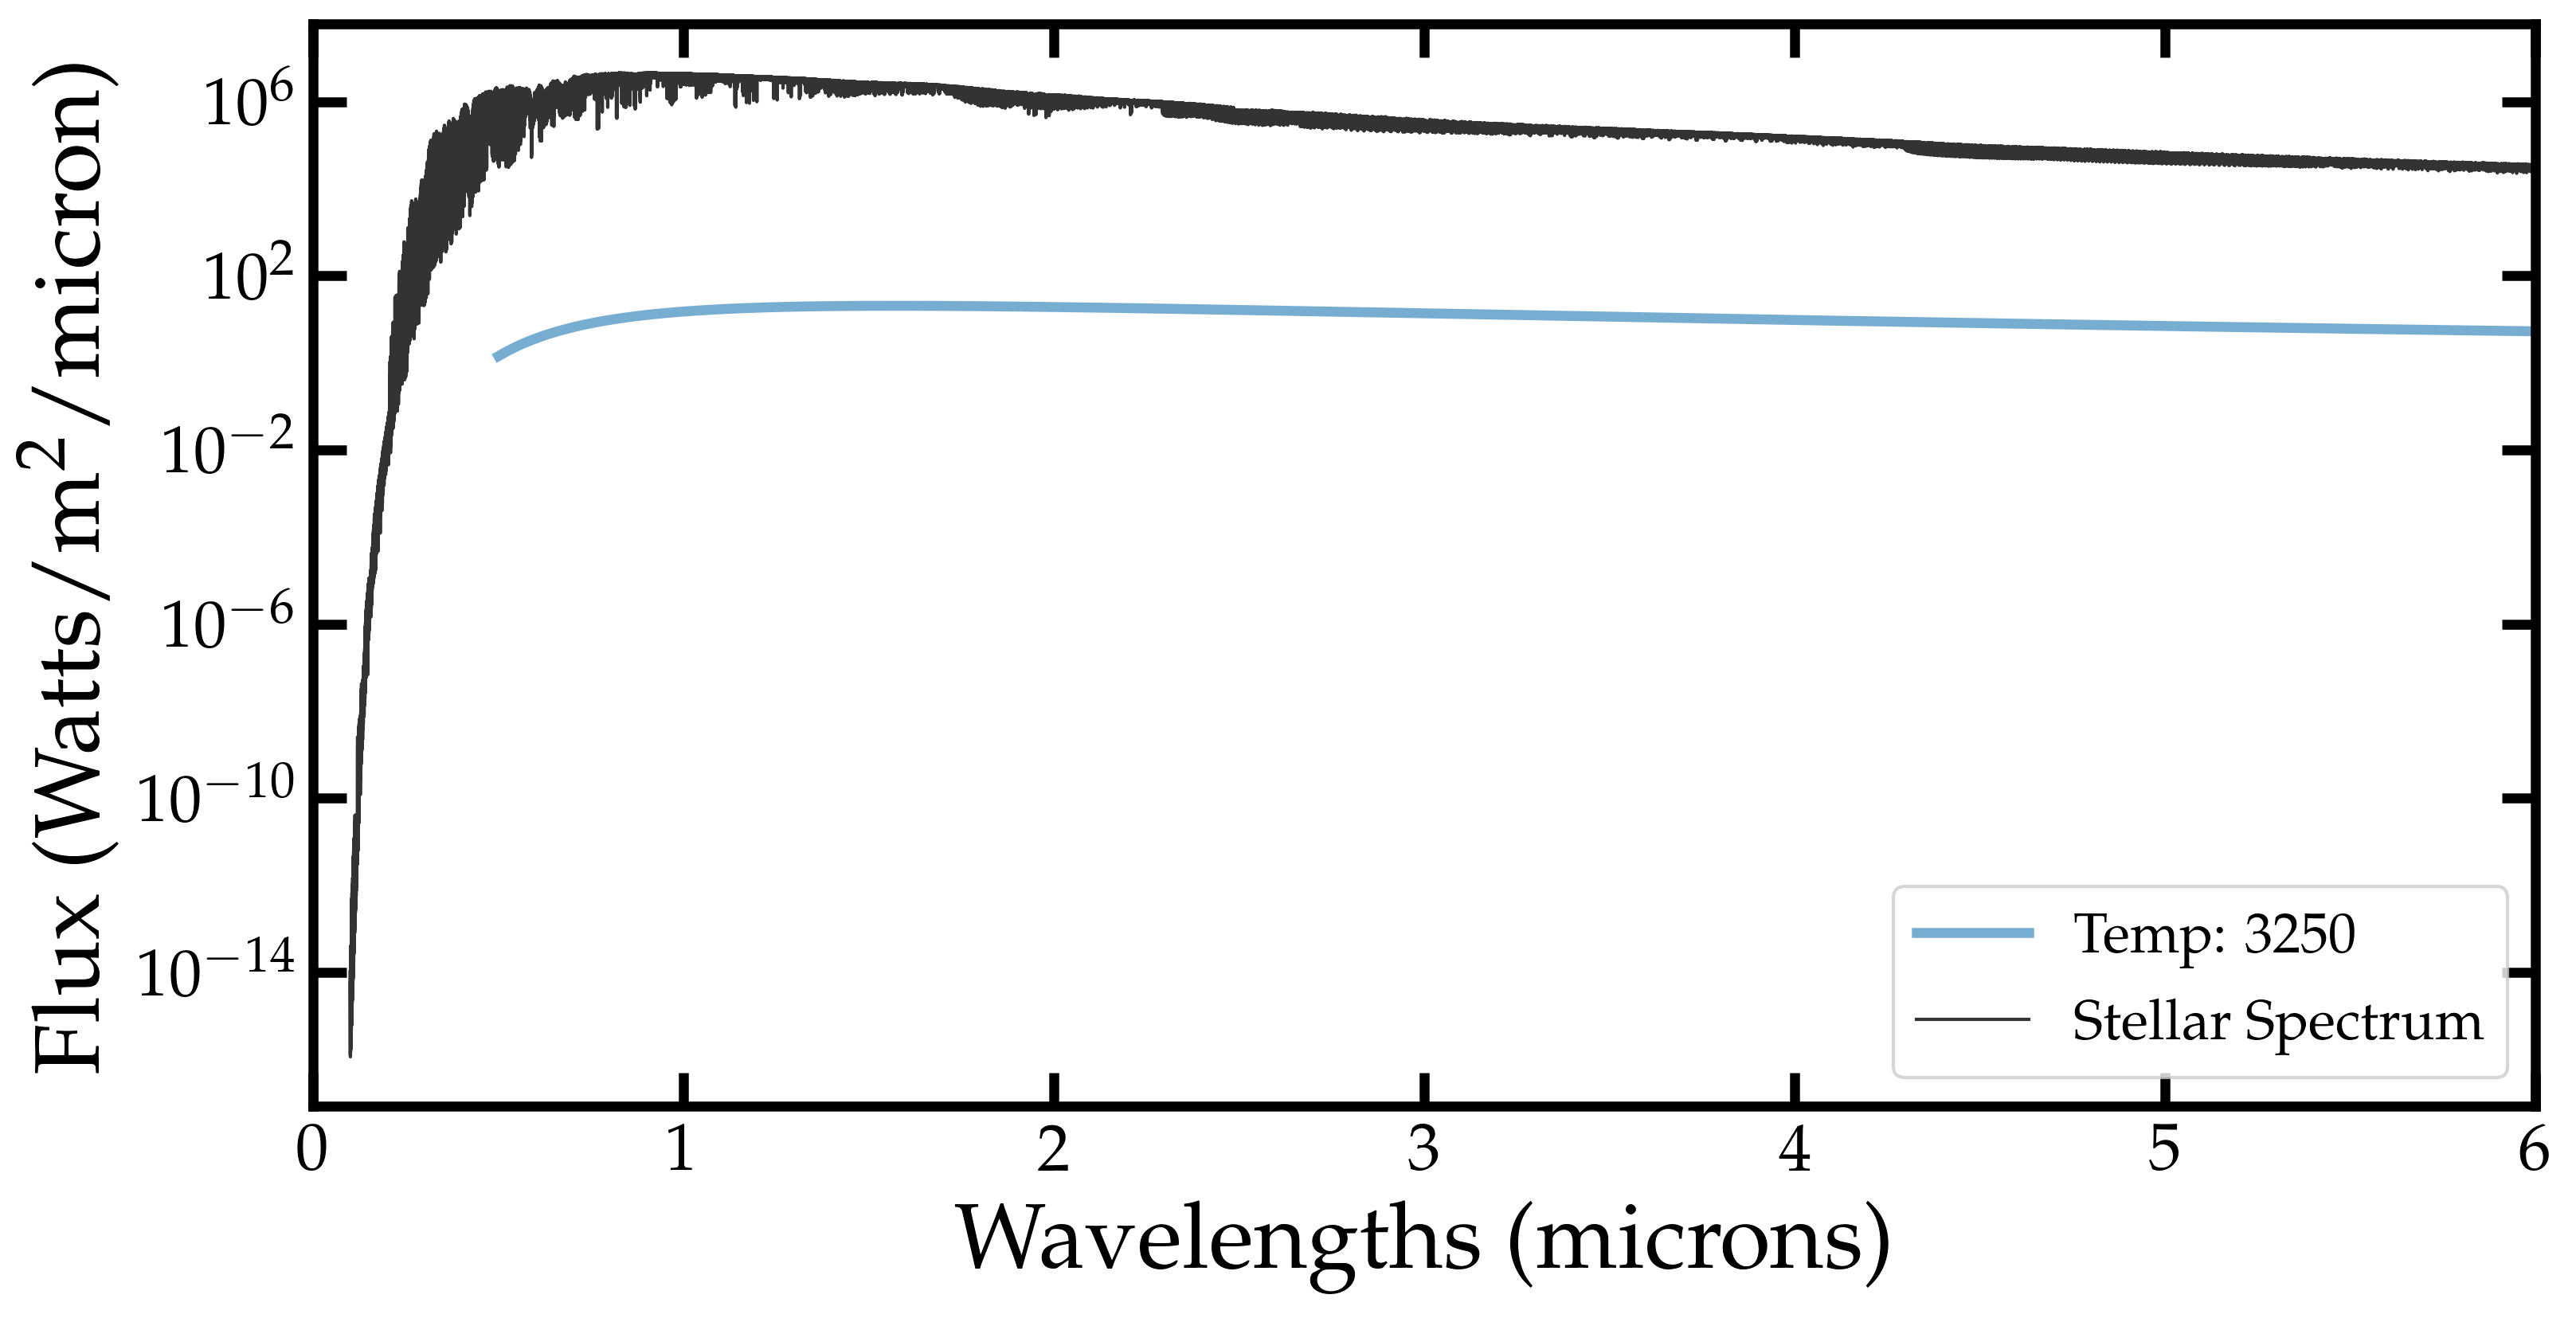

In [21]:
stellar_spectrum_1 = pd.read_csv('DATA/model_3250K.txt', names=['wavelength', 'flux_Watt/m^2/micron'], delim_whitespace=True, skiprows=1)
#stellar_spectrum_1 = pd.read_csv('DATA/PHOENIX_GJ1214b_Cloutier2021_3250_5.02_SPARC.txt', names=['wavelength', 'flux_Watt/m^2/micron'], delim_whitespace=True, skiprows=1)



from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

temps = [3250]
colors_bb = pl.cm.Blues(np.linspace(0,1,len(temps) + 3))

j = 0
for temp in temps:
    bb = BlackBody(temperature=temp*u.K)
    wav = np.linspace(0.5, 20.0, 1000) * u.um
    flux = bb(wav) * np.pi * u.sr
    ax.plot(wav, flux * 1e6, alpha=0.6, linewidth=3, label='Temp: ' + str(temp))
    j = j + 1

    


wavelengths_meters    = np.asarray(list(stellar_spectrum_1.wavelength * 1e-6)) * u.m

flux_Watt_m_2_microns = np.asarray(list(stellar_spectrum_1['flux_Watt/m^2/micron'])) * u.W / u.m**2 / u.um
flux_si = flux_Watt_m_2_microns * np.pi

star_spectra = pd.DataFrame(list(zip(wavelengths_meters.value,flux_si.value)), columns=['wavelength','flux'])
plt.plot(wavelengths_meters * 1e6, flux_si, label='Stellar Spectrum', alpha=0.8, color='black', linewidth=1)

#plt.ylim(1e-3, 20)
plt.yscale('log')
plt.xlabel('Wavelengths (microns)')
plt.ylabel(r'Flux (Watts/m$^2$/micron)')
plt.xlim(0, 6)
plt.legend()

## Create the transmittance filters

In [6]:
df_5 = {'wav': np.linspace(5e-6, 6e-6, 500), 'transmission': np.linspace(1, 1, 500)}
df_5_12 = {'wav': np.linspace(5e-6, 12e-6, 500), 'transmission': np.linspace(1, 1, 500)}


filter_3_6 = pd.read_csv('DATA/filter_3.6.dat', delim_whitespace=True, skiprows=3, names=['wav', 'transmission'])
filter_4_5 = pd.read_csv('DATA/filter_4.5.dat', delim_whitespace=True, skiprows=3, names=['wav', 'transmission'])
filter_5_0 = pd.DataFrame(data=df_5)
filter_5_12 = pd.read_csv('DATA/MIRI_BANDPASS.txt', delim_whitespace=True, skiprows=1, names=['wav', 'transmission'])


# Put the filters in meters
filter_3_6.wav = filter_3_6.wav / 1e6
filter_4_5.wav = filter_4_5.wav / 1e6
filter_5_12.wav = filter_5_12.wav / 1e6

# Interpolate the filters
f_3_6 = interpolate.interp1d(filter_3_6.wav, filter_3_6.transmission)
f_4_5 = interpolate.interp1d(filter_4_5.wav, filter_4_5.transmission)
f_5_0 = interpolate.interp1d(filter_5_0.wav, filter_5_0.transmission)
f_5_12 = interpolate.interp1d(filter_5_12.wav, filter_5_12.transmission)

## Check that the regridded filters work

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


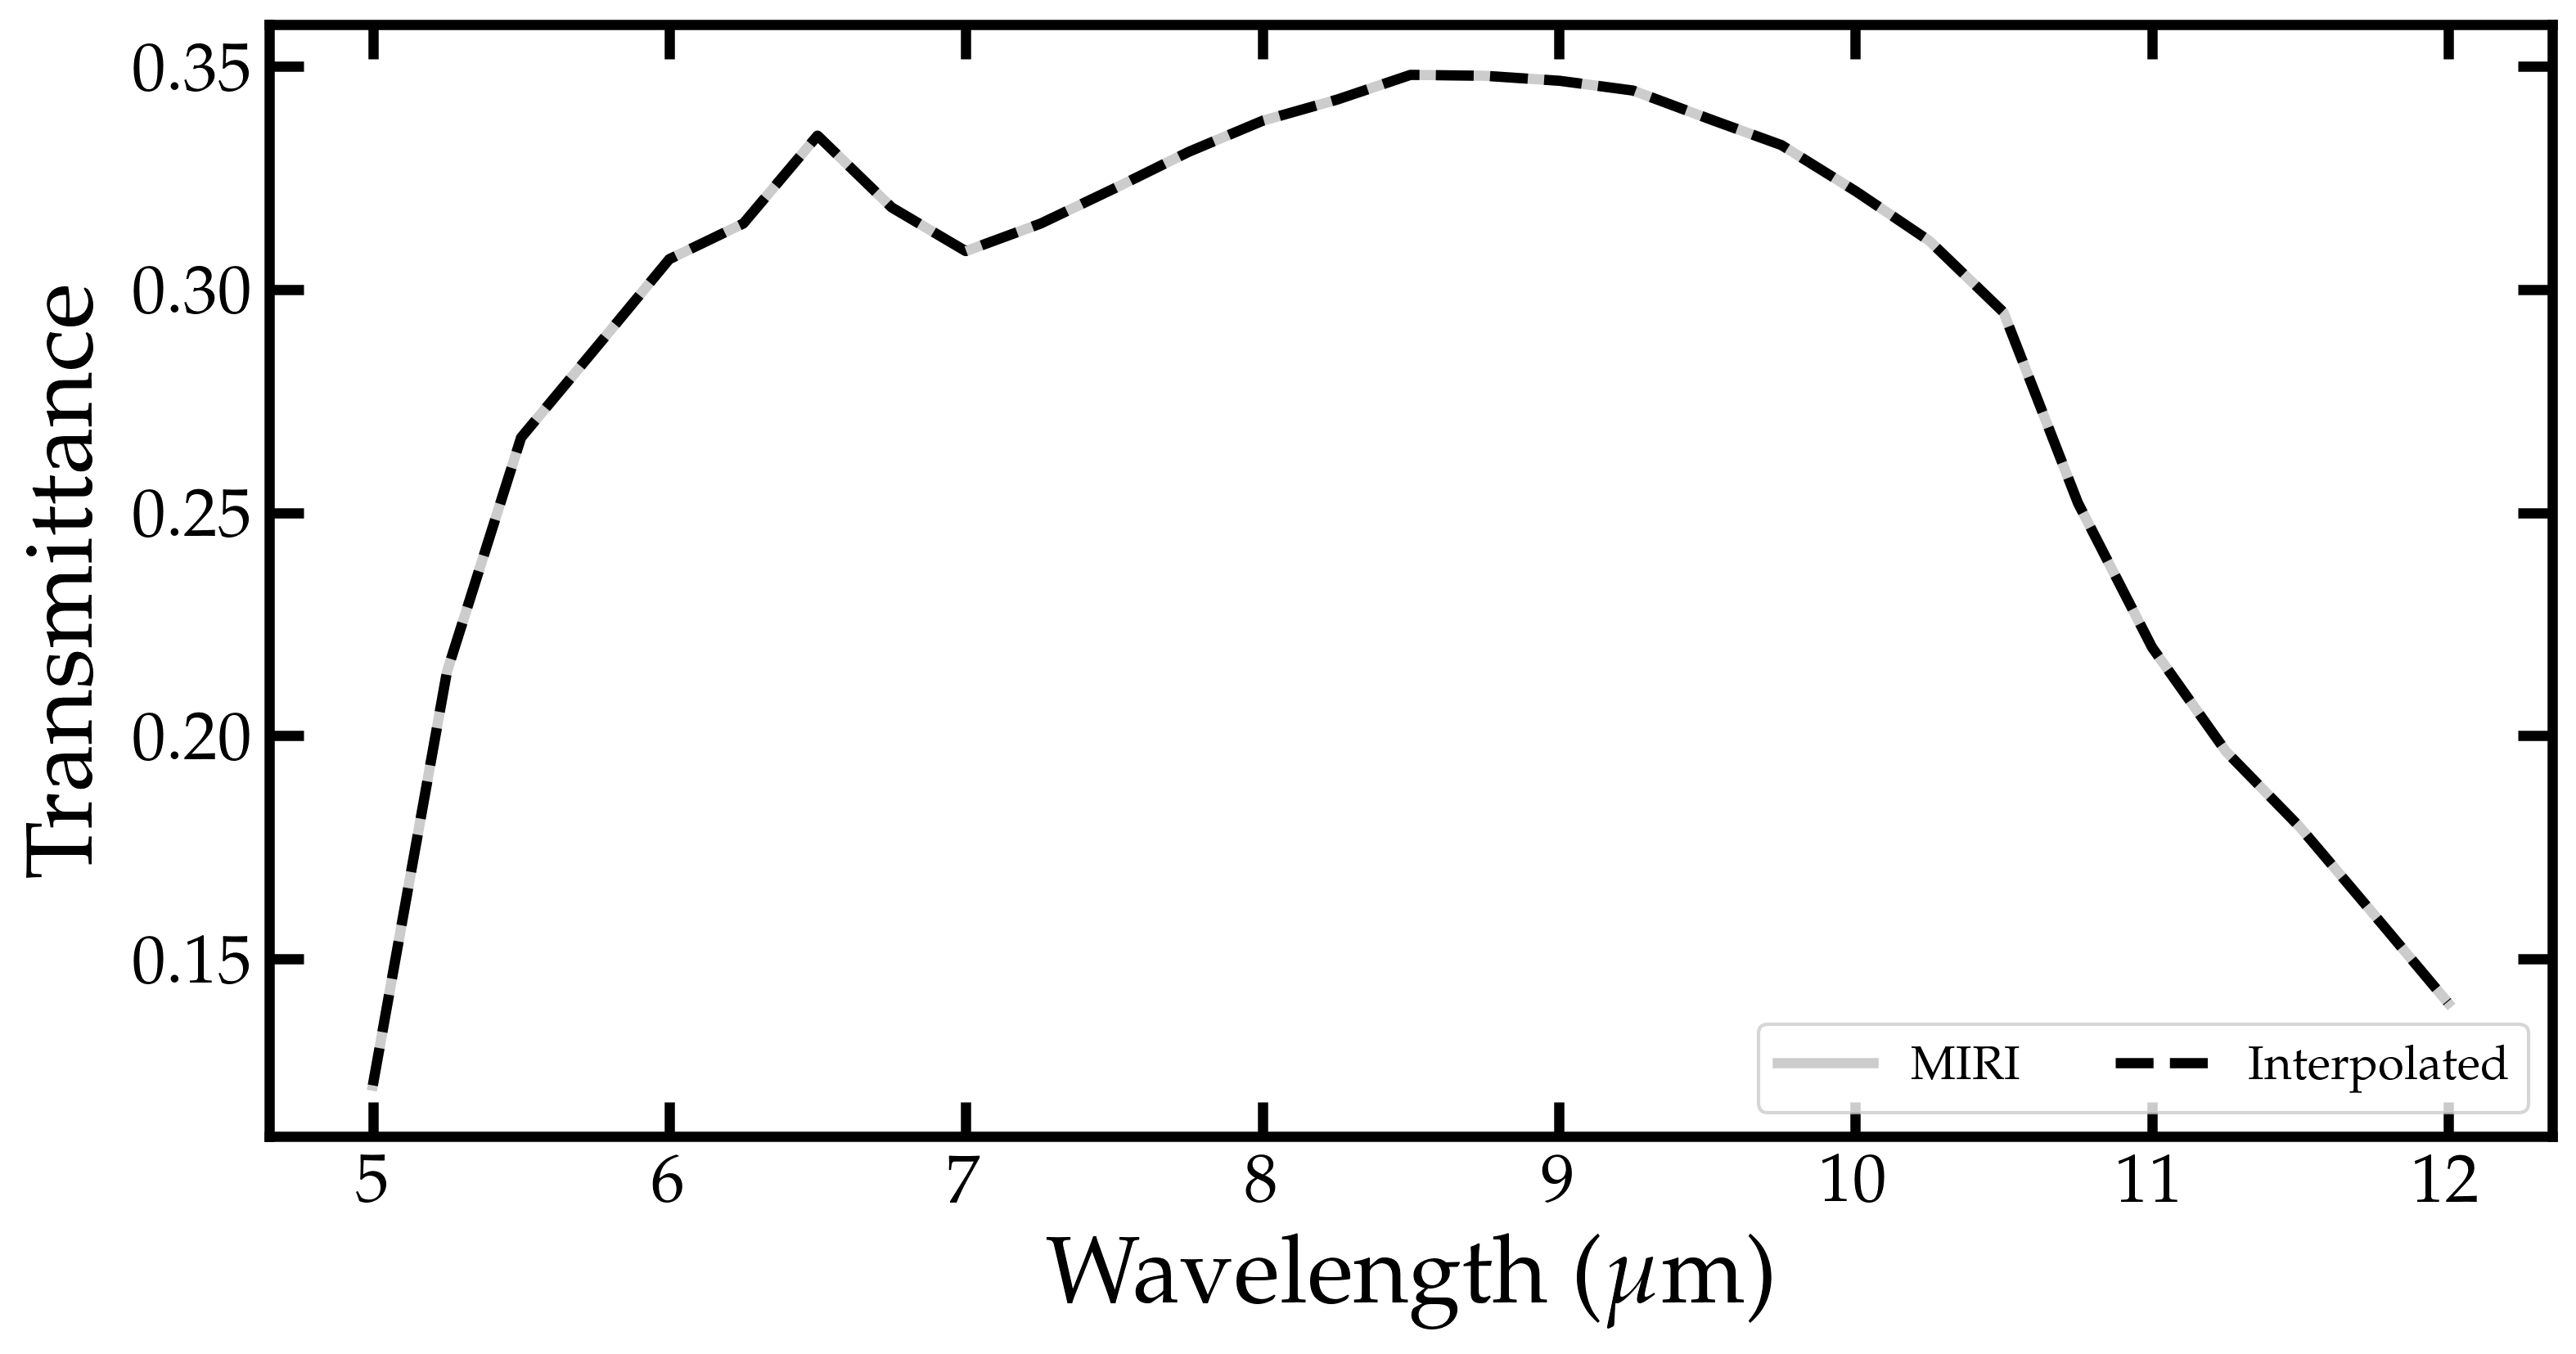

In [7]:
# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.subplots_adjust(hspace=0.05, wspace=0.25)

# Load in a test spectra to get the wavelength ranges
spectra = pd.read_csv('../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_0.0_inc_0.00.00.0000.00.dat', 
                       header=None, delim_whitespace=True, names=['wavelength','flux', 'reflected'])

# Get only the spectra in the filter ranges we care about
spectra_3_6  = spectra[(spectra['wavelength'] > np.amin(filter_3_6.wav)) & (spectra['wavelength'] < np.amax(filter_3_6.wav))]  
spectra_4_5  = spectra[(spectra['wavelength'] > np.amin(filter_4_5.wav)) & (spectra['wavelength'] < np.amax(filter_4_5.wav))]  
spectra_5_12 = spectra[(spectra['wavelength'] > np.amin(filter_5_12.wav)) & (spectra['wavelength'] < np.amax(filter_5_12.wav))]  


# Plot the interpolated transmission stuff and the original ones
#ax.plot(filter_3_6.wav, filter_3_6.transmission, color='#7e1e9c', linewidth=3, alpha=0.2, label="")
#ax.plot(filter_4_5.wav, filter_4_5.transmission, color='#15b01a', linewidth=3, alpha=0.2, label="Original")
ax.plot(filter_5_12.wav * 1e6, filter_5_12.transmission, color='black', linewidth=3, alpha=0.2, label="MIRI")

#ax.plot(spectra_3_6.wavelength, f_3_6(spectra_3_6.wavelength),color='#7e1e9c', linewidth=3, linestyle='dashed', label="Interpolated")
#ax.plot(spectra_4_5.wavelength, f_4_5(spectra_4_5.wavelength),color='#15b01a', linewidth=3, linestyle='dashed', label="Interpolated")
ax.plot(spectra_5_12.wavelength * 1e6, f_5_12(spectra_5_12.wavelength),color='black', linewidth=3, linestyle='dashed', label="Interpolated")


# Some more Figure stuff
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel('Transmittance')
ax.legend(loc='lower right', ncol=2, fontsize=14)
plt.savefig('../Figures/Filters.jpg', dpi=100, bbox_inches='tight')

## Plot the Spectra

In [11]:
"""
# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

plt.rcParams['legend.title_fontsize'] = 18

  
files = ['../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot_phase_0.0_inc_0.00.00.0000.00.dat']

phases = ['0.0']


cm_name = 'RomaO'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file  = np.roll(cm_file, 140, axis=0)
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)
    
    
i = 0
for file in files:
    spectra0 = pd.read_csv(file, header=None, delim_whitespace=True, names=['Wavelength','Flux', 'Reflected'])

    wavelengths = np.asarray(list(spectra0['Wavelength'][10:-10]))
    fluxes      = np.asarray(list(spectra0['Flux'][10:-10]))
    fluxes      = fluxes * (3.0e8 / wavelengths ** 2) / 1e6
    
    ax.plot(wavelengths*1e6, fluxes, label=phases[i]+r'$^\circ$',color=my_colors(i / len(files)), linewidth=1.2)
    ax.legend(fontsize=12, ncol=3, title='Soot Hazes')
    
    i = i + 1

ax.set_yscale('log')
ax.set_ylim(1e-1, 1e4)
ax.set_xlim(0.5,12)
#ax.set_xscale('log')
fig.text(0.5, 0.01, r"Wavelength ($\rm{\mu}m$)", size=26, ha='center')
fig.text(0.03, 0.5, 'Flux (Watts/m$^2$/micron)', size=26, va='center', rotation='vertical')

#plt.savefig('../Figures/WASP43b_Nuc_5.jpg', dpi=100, bbox_inches='tight')
"""

'\n# Figure aesthetics\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)\nplt.subplots_adjust(hspace=0.05, wspace=0.25)\n\nplt.rcParams[\'legend.title_fontsize\'] = 18\n\n  \nfiles = [\'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot_phase_0.0_inc_0.00.00.0000.00.dat\']\n\nphases = [\'0.0\']\n\n\ncm_name = \'RomaO\'\ncm_file = np.loadtxt(f\'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt\')\ncm_file  = np.roll(cm_file, 140, axis=0)\nmy_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)\n    \n    \ni = 0\nfor file in files:\n    spectra0 = pd.read_csv(file, header=None, delim_whitespace=True, names=[\'Wavelength\',\'Flux\', \'Reflected\'])\n\n    wavelengths = np.asarray(list(spectra0[\'Wavelength\'][10:-10]))\n    fluxes      = np.asarray(list(spectra0[\'Flux\'][10:-10]))\n    fluxes      = fluxes * (3.0e8 / wavelengths ** 2) / 1e6\n    \n    ax.plot(wavelengths*1e6, fluxes, label=phases[i]+r\'$^\\circ$\',color=m

## White light stuff

In [12]:

# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

plt.rcParams['legend.title_fontsize'] = 18
  
files = ['../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_0.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_30.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_60.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_90.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_120.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_150.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_180.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_210.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_240.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_270.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_300.0_inc_0.00.00.0000.00.dat',
         '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_330.0_inc_0.00.00.0000.00.dat']


#buda, batlow, roma, 
cm_name = 'romaO'
cm_file = np.loadtxt(f'../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

#colors = ['black', 'red']

colors = pl.cm.plasma(np.linspace(0,1,len(files)))


i = 0
for file in files:
    spectra0 = pd.read_csv(file, header=None, delim_whitespace=True, names=['Wavelength','Flux', 'Reflected'])

    wavelengths = np.asarray(list(spectra0['Wavelength'][10:-10]))
    
    fluxes      = np.asarray(list(spectra0['Flux'][10:-10]))
    fluxes      = fluxes * (3.0e8 / wavelengths ** 2) / 1e6


    reduced_star = np.asarray(reduceSpectralResolution((wavelengths_meters * 1e6).value, (flux_si).value, R_low=100, R_high=None, lambda_mid=None, n=4))
    reduced_planet = np.asarray(reduceSpectralResolution(wavelengths * 1e6, fluxes, R_low=100, R_high=None, lambda_mid=None, n=4))

    f = interpolate.interp1d(wavelengths_meters * 1e6, reduced_star, fill_value='extrapolate')
    
    ratio_ppm = (PLANET_RADIUS / STAR_RADIUS) ** 2 * 1e6 * reduced_planet / f(wavelengths*1e6)
    
    
    ax.plot(wavelengths*1e6, (PLANET_RADIUS / STAR_RADIUS) ** 2 * 1e6 * reduced_planet / f(wavelengths*1e6),
            label=str(i * 30) + r"$^\circ$", color=my_colors(i / len(files)))

    #ax.set_yscale('log')
    ax.legend(fontsize=12, handleheight=1,labelspacing=0.05, ncol=4, title='Phase')
    #ax.set_ylim(0,3000)
    ax.set_xlim(0.5,12)
    #ax.set_ylim(-1,10)
    i = i + 1


plt.title("GJ 1214b 1X Solar Met Soot Hazes", fontsize=24)   
fig.text(0.5, 0.03, r"Wavelength (microns)", size=26, ha='center')
fig.text(0.03, 0.5, r"Planet Flux / Star Flux (ppm)", size=26, va='center', rotation='vertical')

plt.savefig('../Figures/spectra.jpg', dpi=200, bbox_inches='tight')


'\n# Figure aesthetics\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)\nplt.subplots_adjust(hspace=0.05, wspace=0.25)\n\nplt.rcParams[\'legend.title_fontsize\'] = 18\n  \nfiles = [\'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_0.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_30.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_60.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_90.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_120.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_150.0_inc_0.00.00.0000.00.dat\',\n         \'../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_180.0_inc_0.

Text(0, 0.5, 'F$_p$/F$_s$ (ppm)')

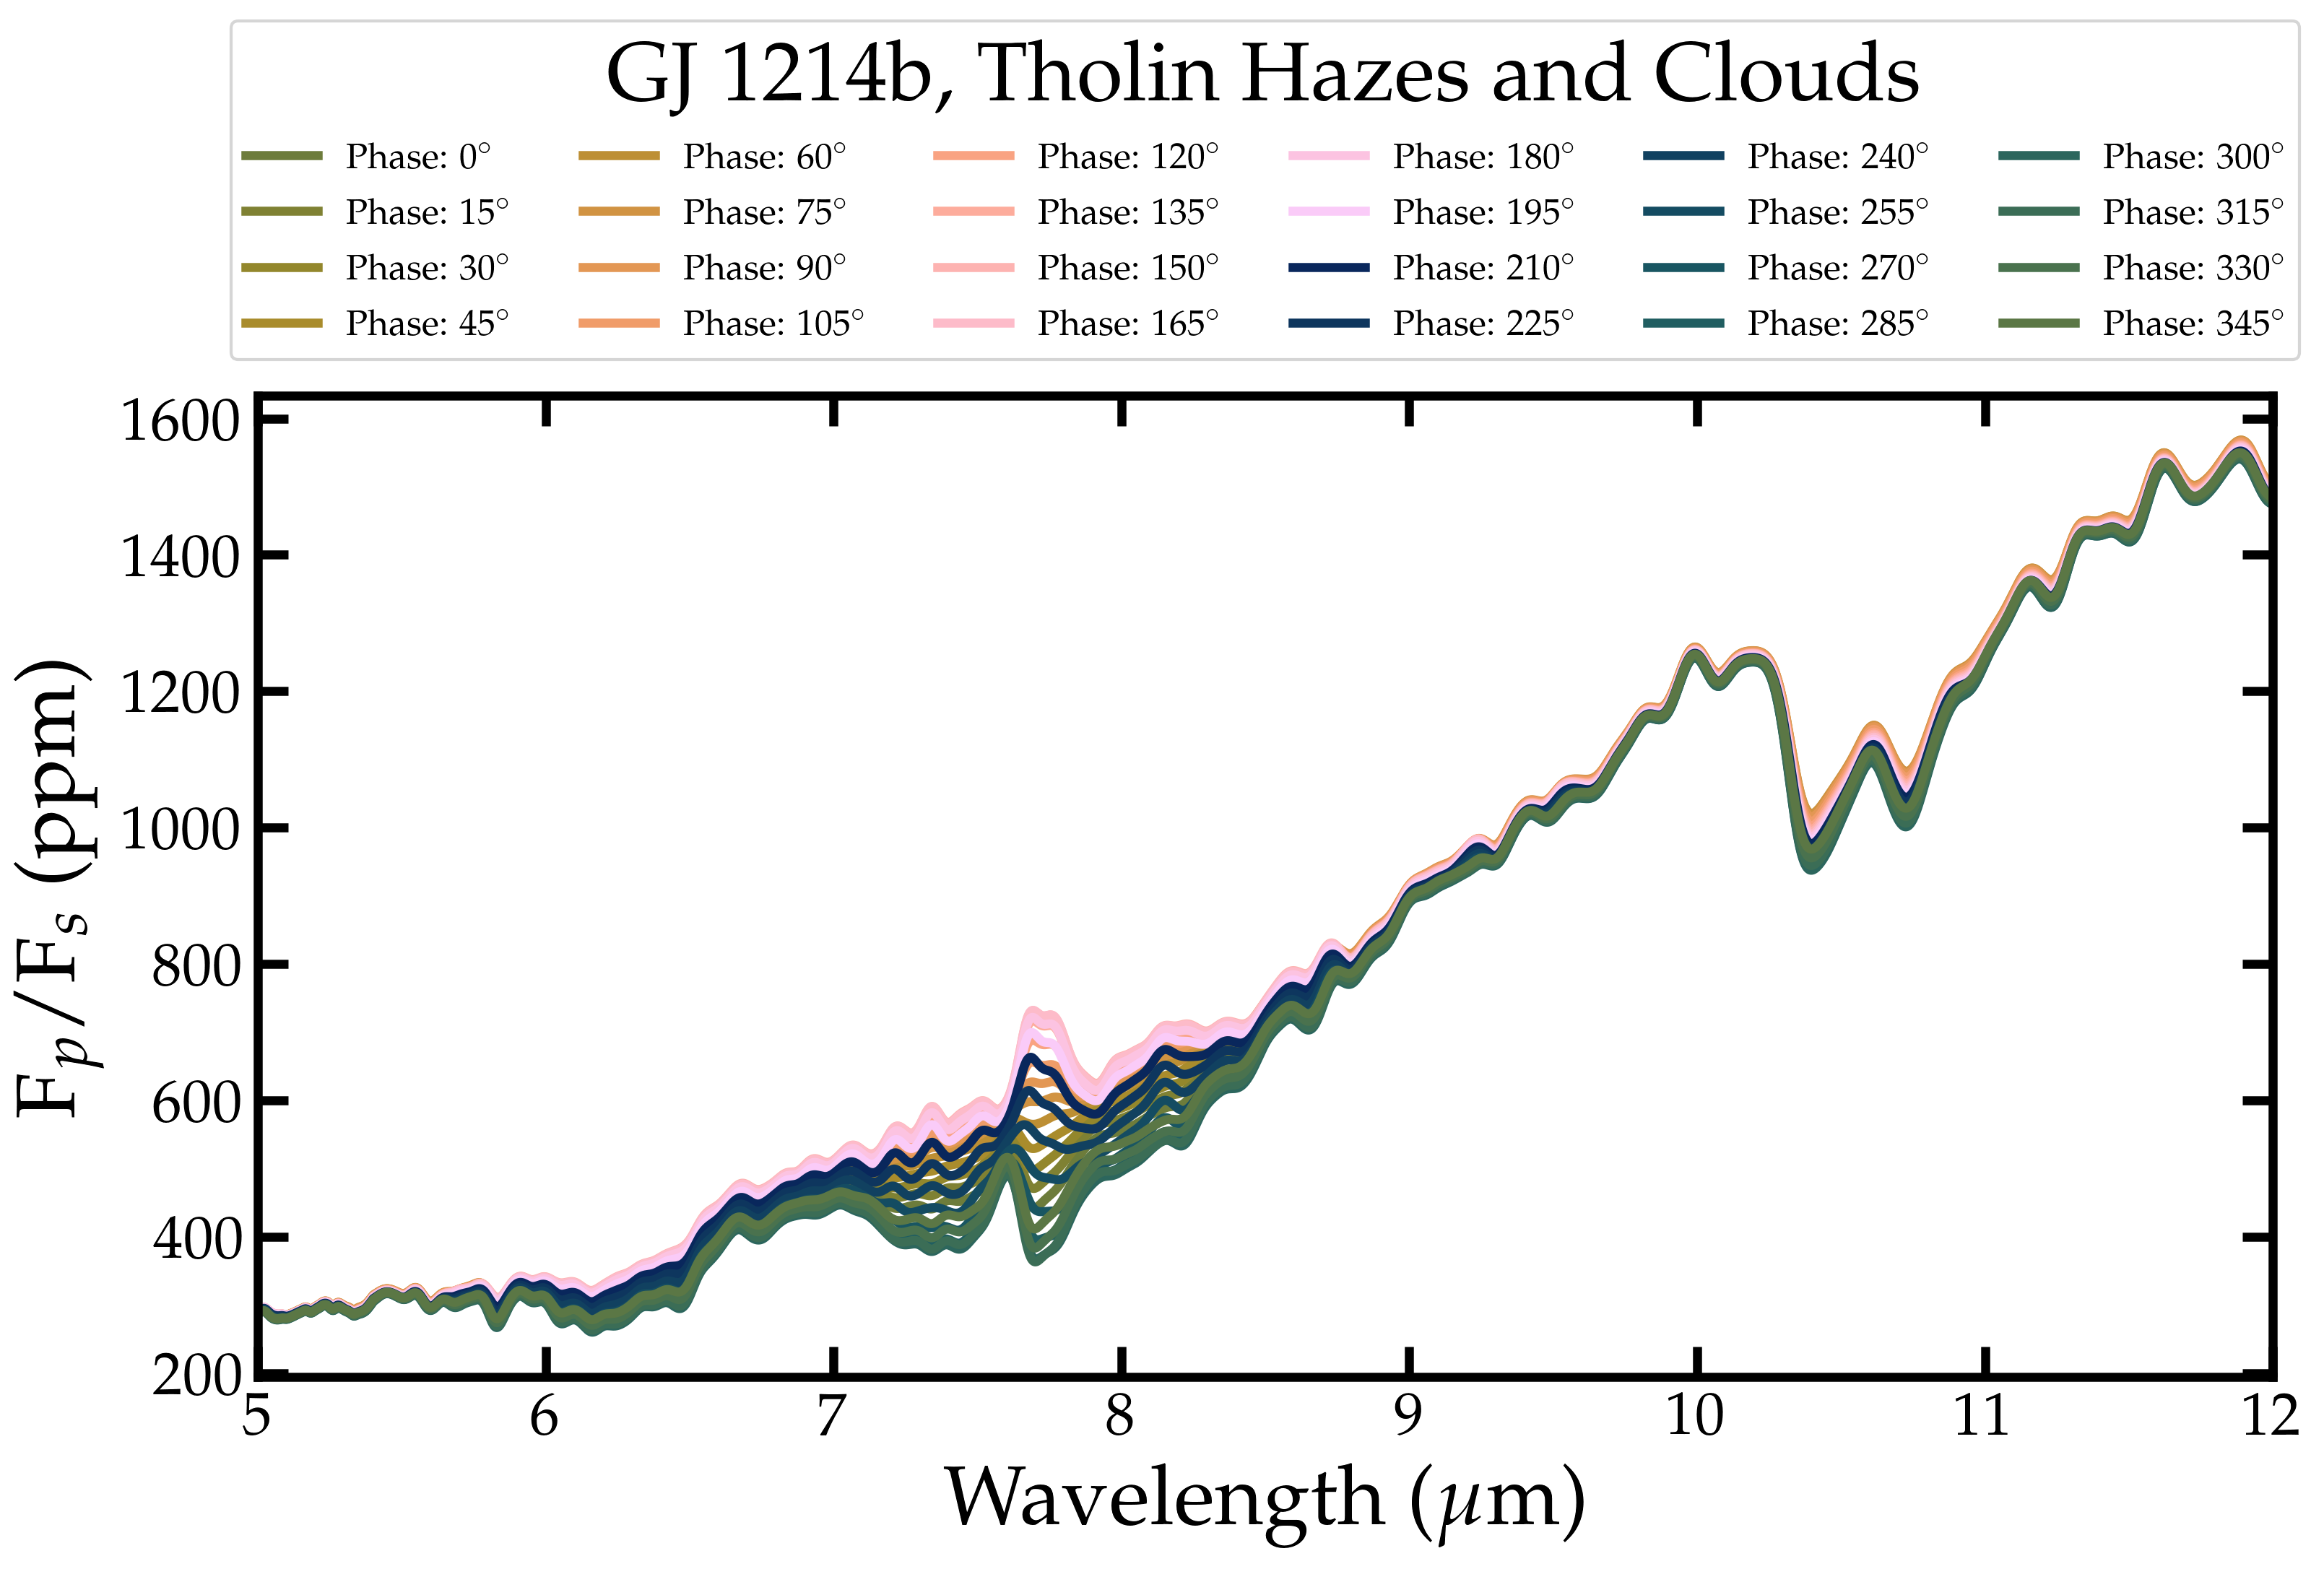

In [40]:
# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)


planets = ['../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-tholin_phase_{}_inc_0.00.00.0000.00.dat']
labels = ["Tholin Hazes and Clouds"]
file_labels=["GJ1214b-HAZES-1X-tholin-CLOUDS"]

cm_name = 'batlow'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file  = np.roll(cm_file, 140, axis=0)
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

spectra_filter = '5_12'

for k, planet in enumerate(planets):
    integrated_signal     = []
    integrated_signal_star = []

    for i in range(24):
        integrated_signal.append(0)
        integrated_signal_star.append(0)
        
        # Load in the planet spectra and convert to per microns
        # The star spectrum is per micron
        planet_spectra = pd.read_csv(planet.format(str(i * 15.0)), header=None, delim_whitespace=True, names=['wavelength','flux', 'reflected'])
        planet_spectra.flux = planet_spectra.flux * (3.0e8 / planet_spectra.wavelength ** 2) / 1e6
        
        # Select the filter
        # Only use the data points within the filter wavelength range that we want
        filt = filter_5_12
        interp_function = f_5_12
        planet_spectra  = planet_spectra[(planet_spectra['wavelength'] > np.amin(filt.wav)) & (planet_spectra['wavelength'] < np.amax(filt.wav))] 
        star_spectra    = star_spectra[(star_spectra['wavelength'] > np.amin(filt.wav)) & (star_spectra['wavelength'] < np.amax(filt.wav))]  
    
        # Reset the indexes of the planet and star dataframes
        planet_spectra = planet_spectra.reset_index(drop=True)
        star_spectra   = star_spectra.reset_index(drop=True)

        
        # Convolve the planet and star down to a lower resolution
        reduced_planet = np.asarray(reduceSpectralResolution(list(planet_spectra.wavelength),
                                                             list(planet_spectra.flux),
                                                             R_low=100, R_high=None, lambda_mid=None, n=4))
        reduced_star = np.asarray(reduceSpectralResolution(list(star_spectra.wavelength),
                                                           list(star_spectra.flux),
                                                           R_low=100, R_high=None, lambda_mid=None, n=4))
        
        # Regrid the star to the same wavelength grid as the planet
        fnc_star_converter      = interpolate.interp1d(star_spectra.wavelength, reduced_star, fill_value='extrapolate')
        regridded_star_spectrum = fnc_star_converter(planet_spectra.wavelength)
 
      
        # Calculate the total signal, and the star signal 
        signal      = (regridded_star_spectrum * STAR_RADIUS**2. + reduced_planet * PLANET_RADIUS**2.) \
                    * (planet_spectra.wavelength / h*c) * interp_function(planet_spectra.wavelength)

        signal_star = (regridded_star_spectrum * STAR_RADIUS**2.) \
                    * (planet_spectra.wavelength / h*c) * interp_function(planet_spectra.wavelength)
        
    
        # Divide out the two integrated signals
        fp_fs_ratio = (signal / signal_star - 1.0)

        ax.plot(planet_spectra.wavelength * 1e6, fp_fs_ratio * 1e6,
                color=my_colors(i / 24),
                linewidth=3,
                label='Phase: ' + str(15 * i) +'$^\circ$')
        #ax.plot(planet_spectra.wavelength * 1e6, reduced_planet,
        #        color=my_colors(i / 24),
        #        linewidth=3,
        #        label='Phase: ' + str(15 * i) +'$^\circ$')

# Figure legend stuff
ax.set_xlim(5,12)    
ax.legend(fontsize=12, ncol=6, title='GJ 1214b, Tholin Hazes and Clouds', bbox_to_anchor=(.5, 1.40), loc='upper center')
ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel(r'F$_p$/F$_s$ (ppm)') #  (W m$^{-2}$)
#plt.savefig('../Figures/GJ_Phase_Curve.jpg', dpi=200, bbox_inches='tight')

Text(0, 0.5, 'F$_p$/F$_s$ (ppm)')

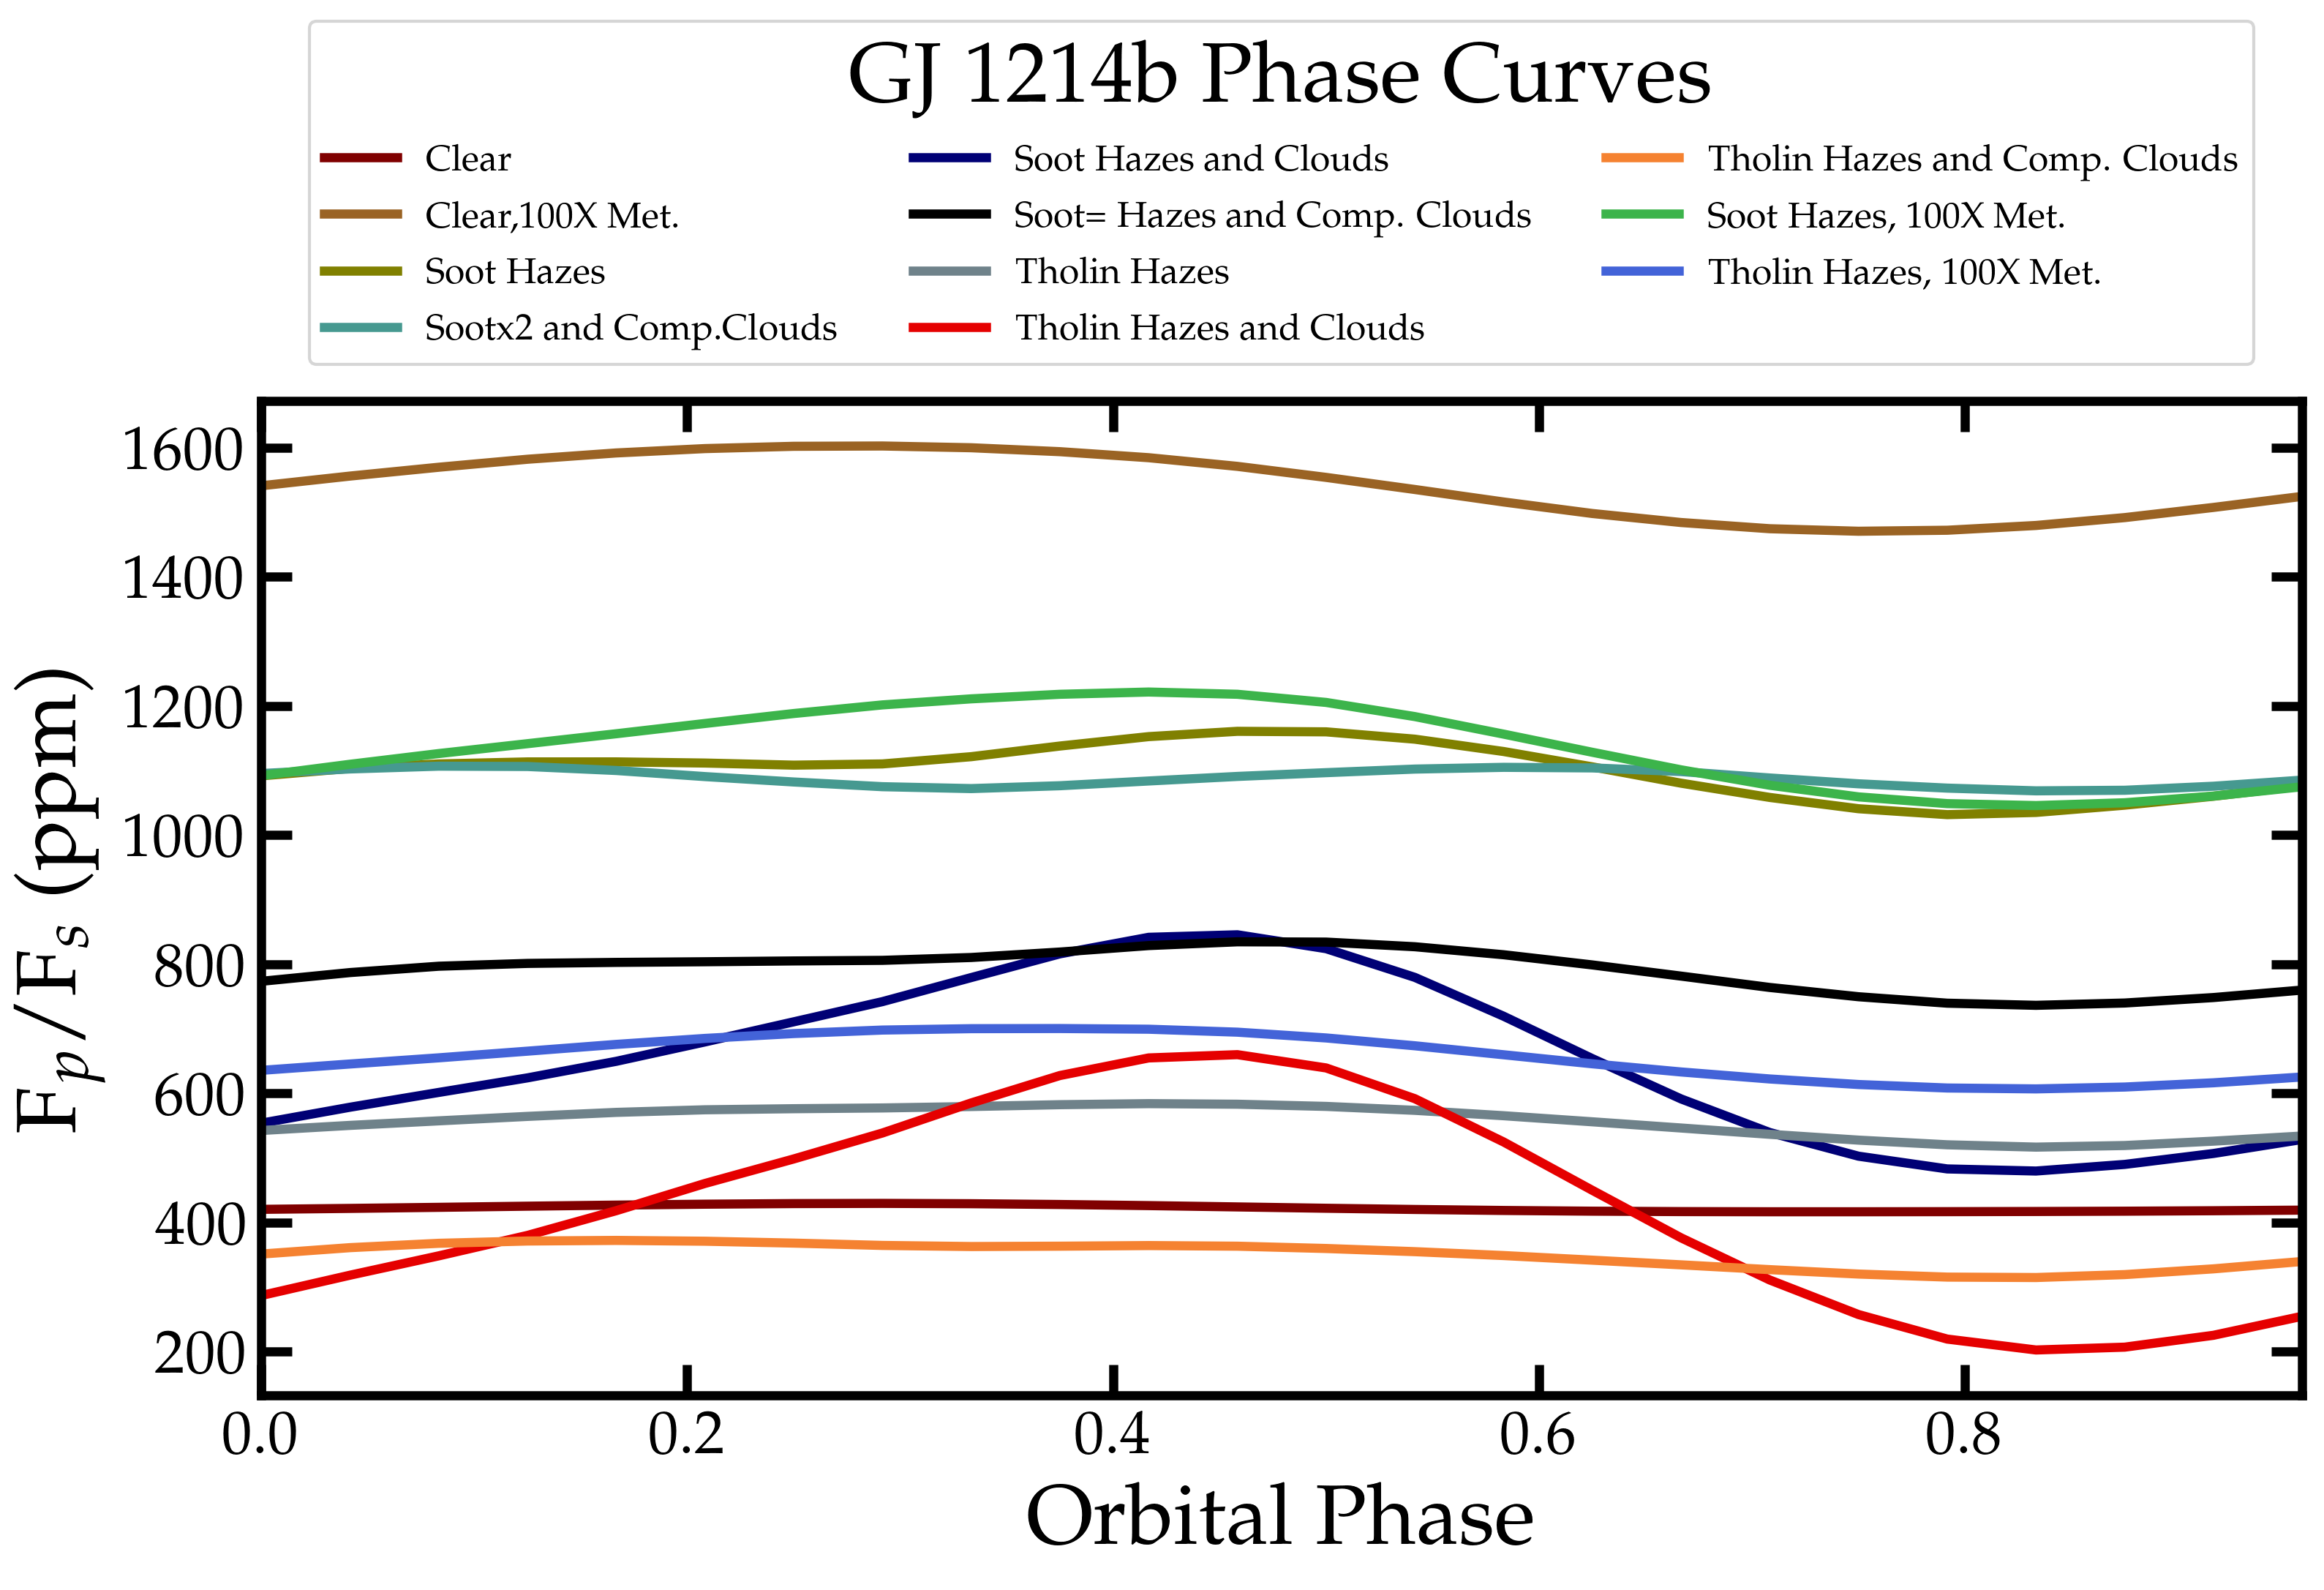

In [26]:
# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)


planets = ['../Spectral-Processing/Spectra/OUT/Spec_0_Clear-0001X-Solar_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_Clear-0100X-Solar_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot2x-CLOUDS-25-layers_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot-CLOUDS_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-soot-CLOUDS-25-layers_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-tholin_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-tholin-CLOUDS_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-1X-tholin-CLOUDS-25-layers_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-soot_phase_{}_inc_0.00.00.0000.00.dat',
           '../Spectral-Processing/Spectra/OUT/Spec_0_GJ1214b-HAZES-100X-tholin_phase_{}_inc_0.00.00.0000.00.dat']
labels = ["Clear",
          "Clear,100X Met.",
          "Soot Hazes",
          "Sootx2 and Comp.Clouds",
          "Soot Hazes and Clouds",
          "Soot= Hazes and Comp. Clouds",
          "Tholin Hazes",
          "Tholin Hazes and Clouds",
          "Tholin Hazes and Comp. Clouds",
          "Soot Hazes, 100X Met.",
          "Tholin Hazes, 100X Met."]
file_labels=["Clear-0001X-Solar",
             "Clear-0100X-Solar",
             "GJ1214b-HAZES-1X-soot",
             "GJ1214b-HAZES-1X-soot2x-CLOUDS-25-layers",
             "GJ1214b-HAZES-1X-soot-CLOUDS",
             "GJ1214b-HAZES-1X-soot-CLOUDS-25-layers",
             "GJ1214b-HAZES-1X-tholin",
             "GJ1214b-HAZES-1X-tholin-CLOUDS",
             "GJ1214b-HAZES-1X-tholin-CLOUDS-25-layers",
             "GJ1214b-HAZES-100X-soot",
             "GJ1214b-HAZES-100X-tholin"]

colors = ["#800000", "#9A6324", "#808000", "#469990", "#000075", "#000000", "#6f828a", "#e50000", "#f58231", "#3cb44b", "#4363d8", "#911eb4", "#f032e6"]

cm_name = 'batlow'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file  = np.roll(cm_file, 140, axis=0)
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

spectra_filter = '5_12'

for k, planet in enumerate(planets):
    integrated_signal     = []
    integrated_signal_star = []

    for i in range(24):
        integrated_signal.append(0)
        integrated_signal_star.append(0)
        
        # Load in the planet spectra and convert to per microns
        # The star spectrum is per micron
        planet_spectra = pd.read_csv(planet.format(str(i * 15.0)), header=None, delim_whitespace=True, names=['wavelength','flux', 'reflected'])
        planet_spectra.flux = planet_spectra.flux * (3.0e8 / planet_spectra.wavelength ** 2) / 1e6
        
        # Select the filter
        # Only use the data points within the filter wavelength range that we want
        filt = filter_5_12
        interp_function = f_5_12
        planet_spectra  = planet_spectra[(planet_spectra['wavelength'] > np.amin(filt.wav)) & (planet_spectra['wavelength'] < np.amax(filt.wav))] 
        star_spectra    = star_spectra[(star_spectra['wavelength'] > np.amin(filt.wav)) & (star_spectra['wavelength'] < np.amax(filt.wav))]  
    
        # Reset the indexes of the planet and star dataframes
        planet_spectra = planet_spectra.reset_index(drop=True)
        star_spectra   = star_spectra.reset_index(drop=True)

        
        # Convolve the planet and star down to a lower resolution
        #reduced_planet = np.asarray(reduceSpectralResolution(list(planet_spectra.wavelength),
        #                                                     list(planet_spectra.flux),
        #                                                     R_low=100, R_high=None, lambda_mid=None, n=4))
        #reduced_star = np.asarray(reduceSpectralResolution(list(star_spectra.wavelength),
        #                                                   list(star_spectra.flux),
        #                                                   R_low=100, R_high=None, lambda_mid=None, n=4))
        
        # Regrid the star to the same wavelength grid as the planet
        fnc_star_converter      = interpolate.interp1d(star_spectra.wavelength, star_spectra.flux, fill_value='extrapolate')
        regridded_star_spectrum = fnc_star_converter(planet_spectra.wavelength)
 
      
        # Calculate the total signal, and the star signal 
        signal      = (regridded_star_spectrum * STAR_RADIUS**2. + planet_spectra.flux * PLANET_RADIUS**2.) \
                    * (planet_spectra.wavelength / h*c) * interp_function(planet_spectra.wavelength)

        signal_star = (regridded_star_spectrum * STAR_RADIUS**2.) \
                    * (planet_spectra.wavelength / h*c) * interp_function(planet_spectra.wavelength)
        
        # Integrate the total signal and the star signal
        integrated_signal[i]      = trapz(signal, x=planet_spectra.wavelength)
        integrated_signal_star[i] = trapz(signal_star,  x=planet_spectra.wavelength)
        
    # Convert both the signal and the star signal to arrays 
    integrated_signal      = np.asarray(integrated_signal)
    integrated_signal_star = np.asarray(integrated_signal_star)
    
    # Divide out the two integrated signals
    fp_fs_ratio = (integrated_signal / integrated_signal_star - 1.0)
    
    # Save the data
    pd.DataFrame({'Phase':np.arange(0, 360, 4*3.75), 'fp_fs_ratio':fp_fs_ratio*1e6}).to_csv('DATA/Phase_Curve_{}.txt'.format(file_labels[k]), sep=' ')
    
    # Plot the data
    phases = np.arange(0, 360, 4*3.75) / 360
    ax.plot(phases,fp_fs_ratio * 1e6,
            #color=my_colors(k / len(planets)),
            color=colors[k],
            linewidth=3,label=labels[k])

# Figure legend stuff
ax.set_xlim(min(phases),max(phases))    
ax.legend(fontsize=12, ncol=3, title='GJ 1214b Phase Curves', bbox_to_anchor=(.5, 1.40), loc='upper center')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel(r'F$_p$/F$_s$ (ppm)') #  (W m$^{-2}$)
#plt.savefig('../Figures/GJ_Phase_Curve.jpg', dpi=200, bbox_inches='tight')

Text(0, 0.5, 'F$_p$/F$_s$ (ppm)')

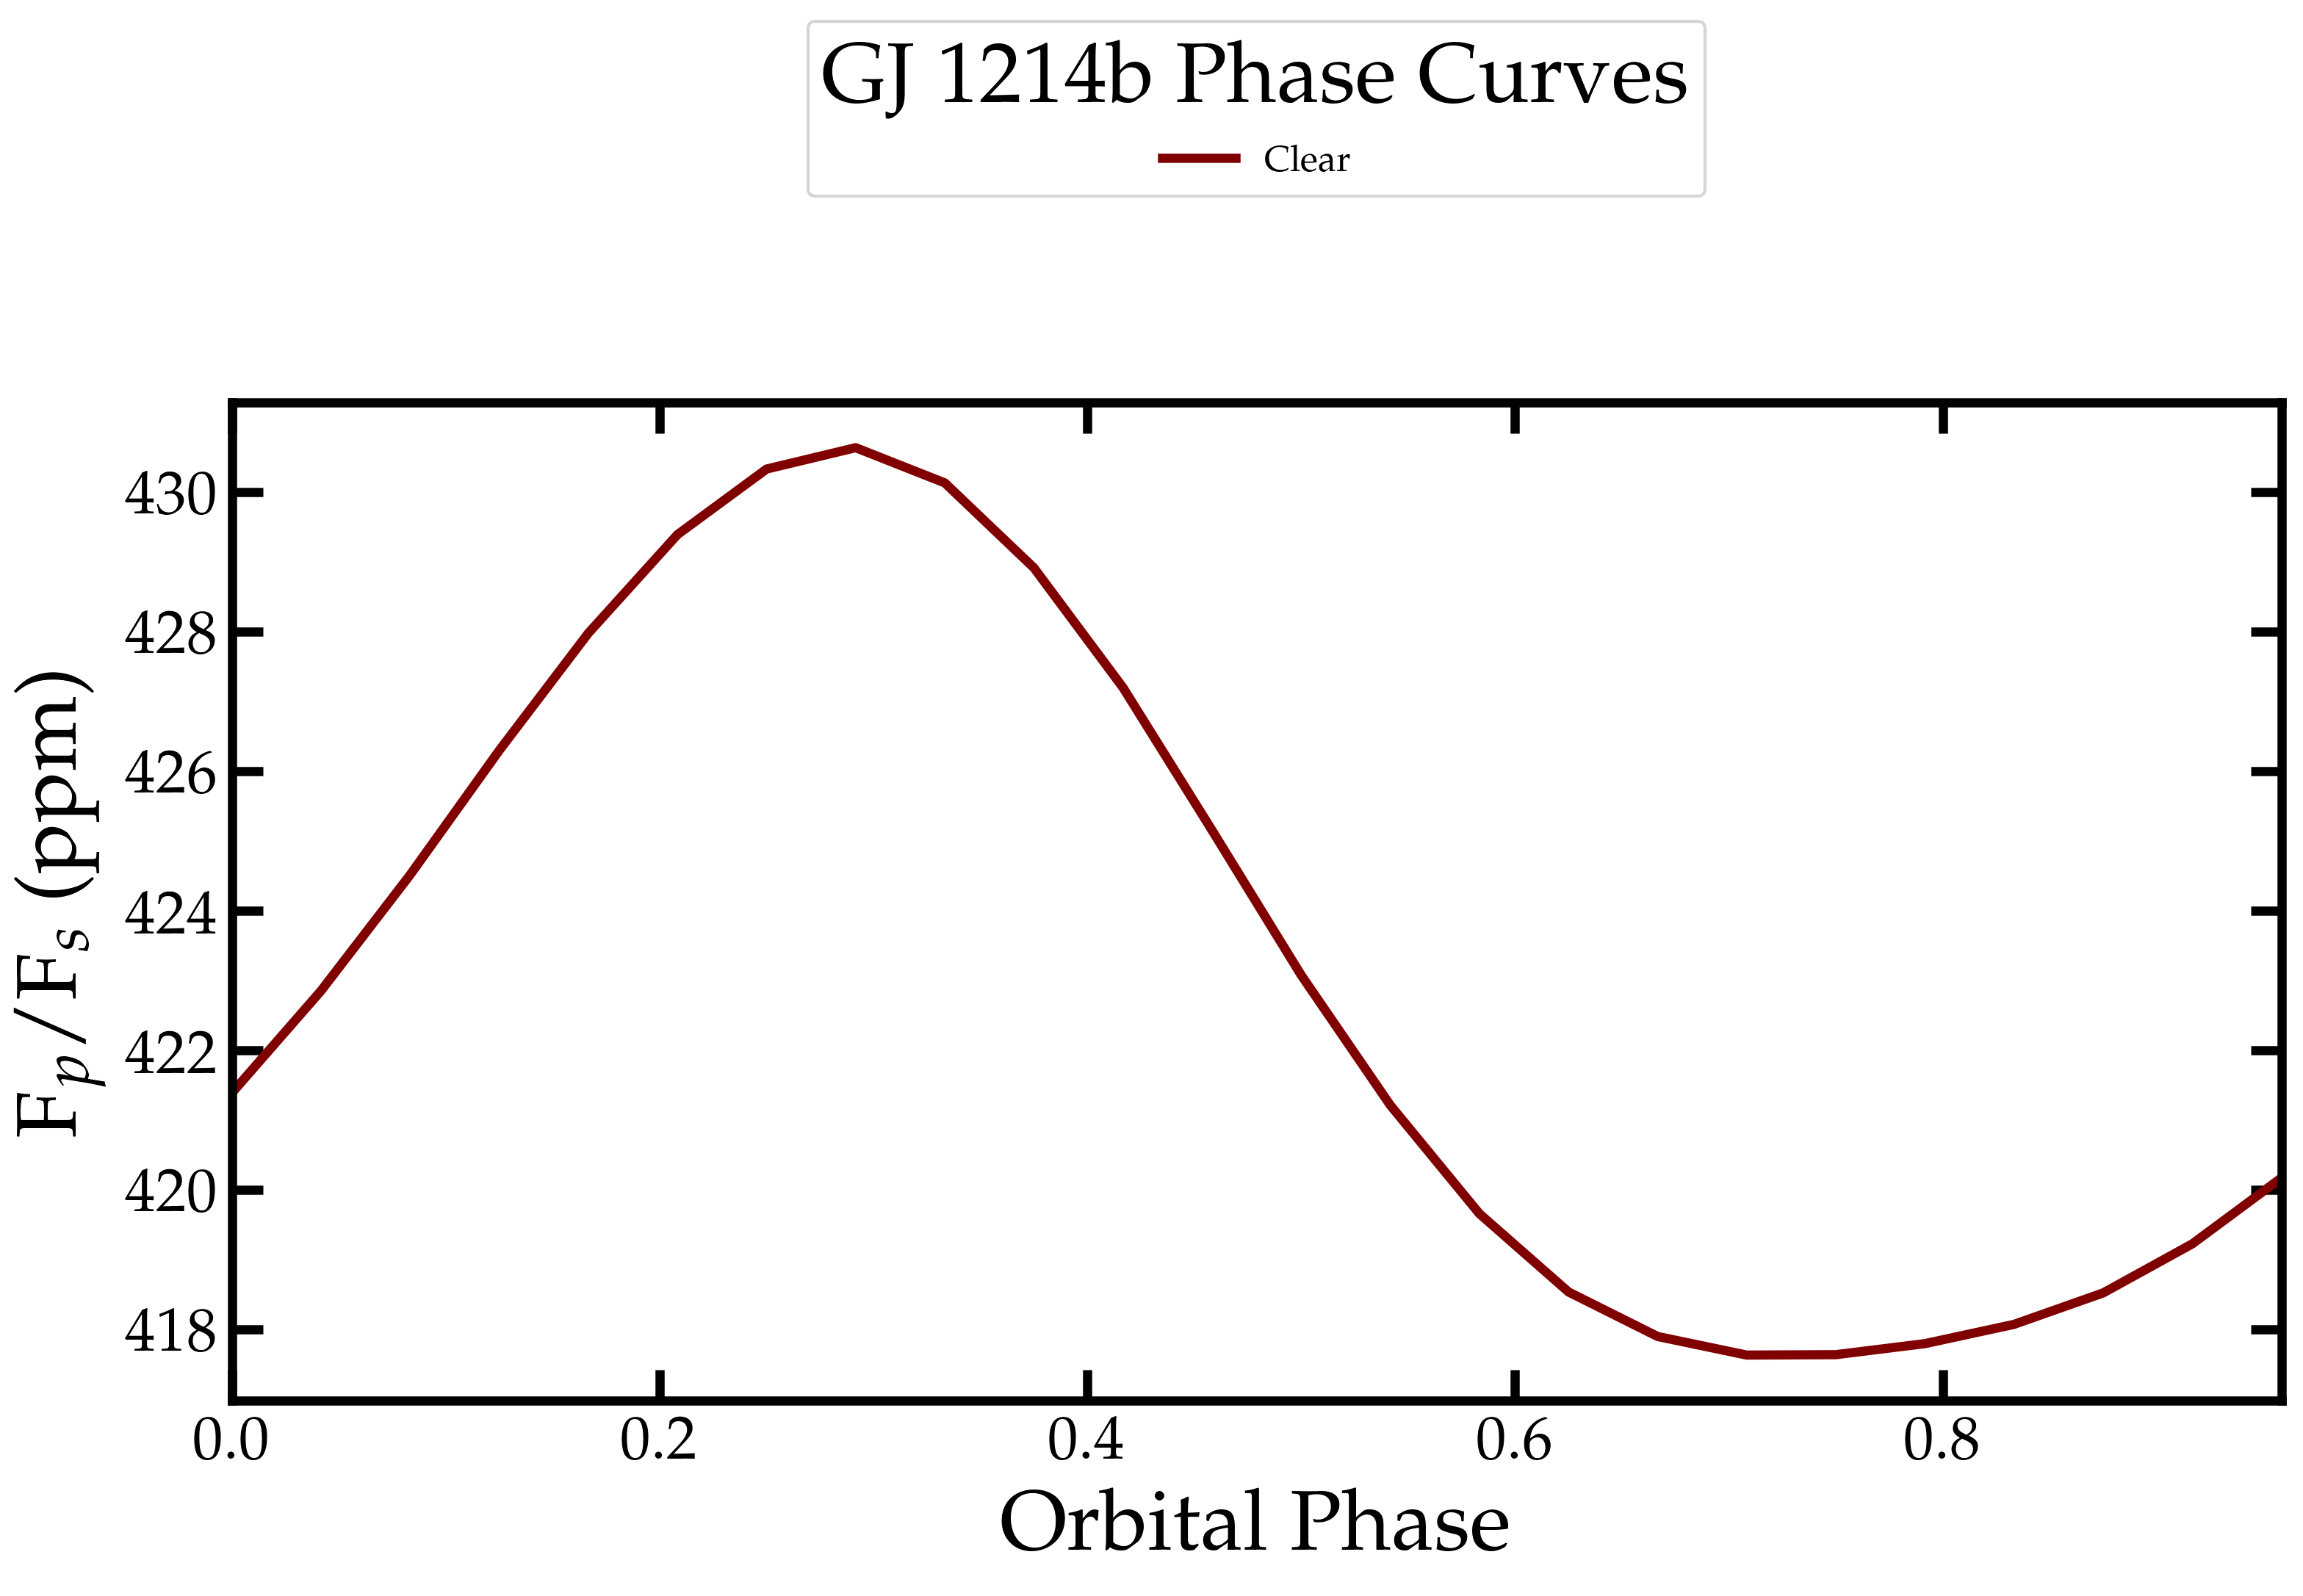

In [43]:
cm_name = 'batlow'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file  = np.roll(cm_file, 140, axis=0)
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

# Figure aesthetics
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6),sharex=True, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

colors = ["#800000", "#9A6324", "#808000", "#469990", "#000075", "#000000", "#6f828a", "#e50000", "#f58231", "#3cb44b", "#4363d8", "#911eb4", "#f032e6"]



#for k in range(len(file_labels)):
for k in range(1):
    df = pd.read_csv('DATA/Phase_Curve_{}.txt'.format(file_labels[k]), sep=' ')
    linestyle_str = 'solid'
    
    #if k < 4:
    #    linestyle_str = 'solid'
    #elif 4 <= k < 8:
    #    linestyle_str = 'dashed'
    #else:
    #    linestyle_str = 'dotted'
    
    ax.plot(df.Phase / 360.0, df.fp_fs_ratio,
            color = colors[k],
            #color=my_colors(k / len(planets)),
            linewidth=3,label=labels[k],
            linestyle=linestyle_str)
    
    
# Figure legend stuff
ax.set_xlim(min(phases),max(phases))    
ax.legend(fontsize=12, ncol=3, title='GJ 1214b Phase Curves', bbox_to_anchor=(.5, 1.40), loc='upper center')
ax.set_xlabel('Orbital Phase')
ax.set_ylabel(r'F$_p$/F$_s$ (ppm)')